# Quick check converted data looks OK

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import dask

dask.config.set(scheduler='threads')
xr.set_options(display_style='text')

ModuleNotFoundError: No module named 'dask'

In [2]:
import glob
files = glob.glob('/scratch/pawsey0106/pbranson/Cyl*.nc')

dsets = []
attrs = []
for f in files:
    ds = xr.open_dataset(f,chunks='auto')
    dsets.append(ds)
    attrs.append(ds.attrs)
ds

<xarray.Dataset>
Dimensions:  (time: 138, x: 64, y: 48, z: 45)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-13T12:31:42.727000 ... 2016-07-13T...
  * x        (x) float32 0.01056 0.01584 0.02112 0.0264 ... 0.3326 0.3379 0.3432
  * y        (y) float32 0.01056 0.01584 0.02112 0.0264 ... 0.2482 0.2534 0.2587
  * z        (z) float32 0.003 0.0045 0.006 0.0075 ... 0.0645 0.066 0.0675 0.069
Data variables:
    U        (time, x, y, z) float32 dask.array<chunksize=(138, 64, 48, 45), meta=np.ndarray>
    V        (time, x, y, z) float32 dask.array<chunksize=(138, 64, 48, 45), meta=np.ndarray>
    W        (time, x, y, z) float32 dask.array<chunksize=(138, 64, 48, 45), meta=np.ndarray>
Attributes: (12/24)
    XML:                     <config>\n\t<runFolder>/scratch/pawsey0106/pbran...
    captureDt:               0.05
    capture_burst_interval:  1.0
    capture_n_burst:         11
    dx:                      0.005280000157654285
    dy:                      0.005280000157654285
    ...                      ...
    run_id:                  CylinderTest02
    source:                  3DPIV applied to Synthetic Aperture Imagery
    title:                   Three dimensional particle imaging velocimetry data
    velocityError:           0.15673570334911346
    vorticityError:          0.2269086390733719
    license:                 https://creativecommons.org/licenses/by/4.0/lega...

In [3]:
df = pd.DataFrame(attrs)
df

,XML,captureDt,capture_burst_interval,capture_n_burst,dx,dy,dz,filename,institution,pdx,...,piv_step_ensemble,piv_step_frame,piv_tag,references,run_id,source,title,velocityError,vorticityError,license
0,<config>\n\t<runFolder>/scratch/pawsey0106/pbr...,0.05,1.0,11,0.00528,0.00528,0.0015,/scratch/pawsey0106/pbranson/Exp6/Stage2/Cylin...,University of Western Australia,0.00022,...,0.25,1.0,G0_dt1.00_de0.25_ne3,"Branson, P. M. (2019). Laboratory study of cir...",CylinderTest02,3DPIV applied to Synthetic Aperture Imagery,Three dimensional particle imaging velocimetry...,0.451238,0.142846,https://creativecommons.org/licenses/by/4.0/le...
1,<config>\n\t<runFolder>/scratch/pawsey0106/pbr...,0.05,1.0,11,0.00528,0.00528,0.0015,/scratch/pawsey0106/pbranson/Exp6/Stage2/Cylin...,University of Western Australia,0.00022,...,0.50,2.0,G0_dt2.00_de0.50_ne4,"Branson, P. M. (2019). Laboratory study of cir...",CylinderTest02,3DPIV applied to Synthetic Aperture Imagery,Three dimensional particle imaging velocimetry...,0.818435,0.154318,https://creativecommons.org/licenses/by/4.0/le...
2,<config>\n\t<runFolder>/scratch/pawsey0106/pbr...,0.05,1.0,11,0.00528,0.00528,0.0015,/scratch/pawsey0106/pbranson/Exp6/Stage2/Cylin...,University of Western Australia,0.00022,...,0.10,1.0,G0_dt1.00_de0.10_ne5,"Branson, P. M. (2019). Laboratory study of cir...",CylinderTest02,3DPIV applied to Synthetic Aperture Imagery,Three dimensional particle imaging velocimetry...,0.202483,0.149428,https://creativecommons.org/licenses/by/4.0/le...
3,<config>\n\t<runFolder>/scratch/pawsey0106/pbr...,0.05,1.0,11,0.00528,0.00528,0.0015,/scratch/pawsey0106/pbranson/Exp6/Stage2/Cylin...,University of Western Australia,0.00022,...,0.15,1.0,G0_dt1.00_de0.15_ne4,"Branson, P. M. (2019). Laboratory study of cir...",CylinderTest02,3DPIV applied to Synthetic Aperture Imagery,Three dimensional particle imaging velocimetry...,0.315662,0.156875,https://creativecommons.org/licenses/by/4.0/le...
4,<config>\n\t<runFolder>/scratch/pawsey0106/pbr...,0.05,1.0,11,0.00528,0.00528,0.0015,/scratch/pawsey0106/pbranson/Exp6/Stage2/Cylin...,University of Western Australia,0.00022,...,0.05,1.0,G0_dt1.00_de0.05_ne5,"Branson, P. M. (2019). Laboratory study of cir...",CylinderTest02,3DPIV applied to Synthetic Aperture Imagery,Three dimensional particle imaging velocimetry...,0.156736,0.226909,https://creativecommons.org/licenses/by/4.0/le...


In [4]:
#concatenate the different analyses along a new dimension
ds = xr.concat(dsets,dim=df.piv_tag)

# Zero the time 
ds['time'] = (ds['time'] - ds['time'][0])/pd.to_timedelta(1,'s')

volMean = ds.stack(space=['x','y','z']).mean(dim='space')
rms = np.sqrt(((ds.stack(space=['x','y','z'])-volMean)**2).mean(dim='space'))

## Plot of volume means

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


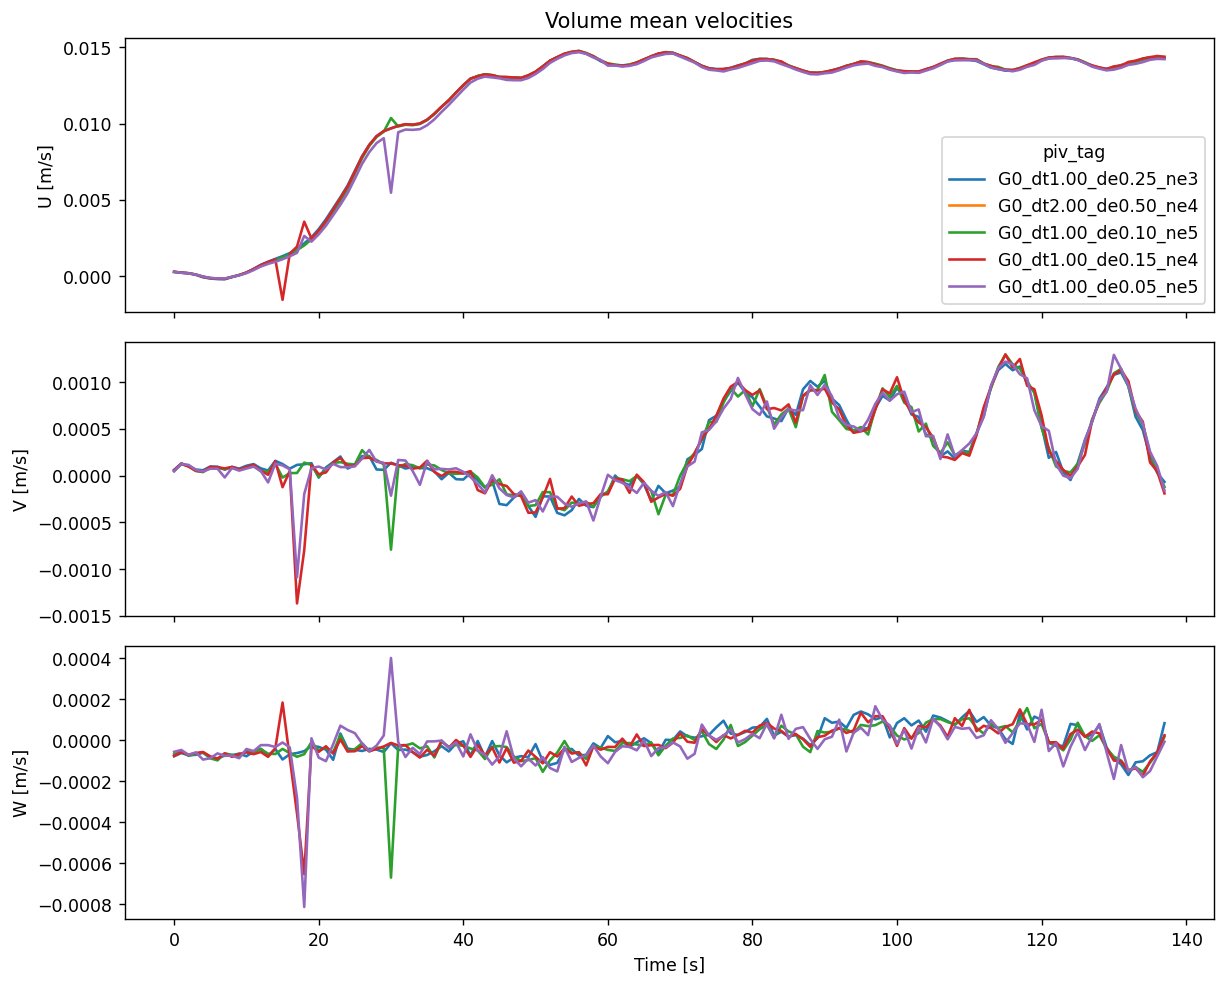

In [5]:
import matplotlib.pyplot as plt
vv = ['U','V','W']
fig,ax = plt.subplots(3,1,figsize=(10,8),dpi=125,sharex=True)
for i,v in enumerate(vv):
    if i > 0:
        legend=False
    else:
        legend=True
        
    volMean[v].plot(ax=ax[i],hue='piv_tag',add_legend=legend)
    
    ax[i].set_ylabel(f'{v} [m/s]')
ax[0].set_title('Volume mean velocities')
for a in ax:
    a.set_xlabel('')
a.set_xlabel('Time [s]')
fig.tight_layout()

## Plot of RMS velocities

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


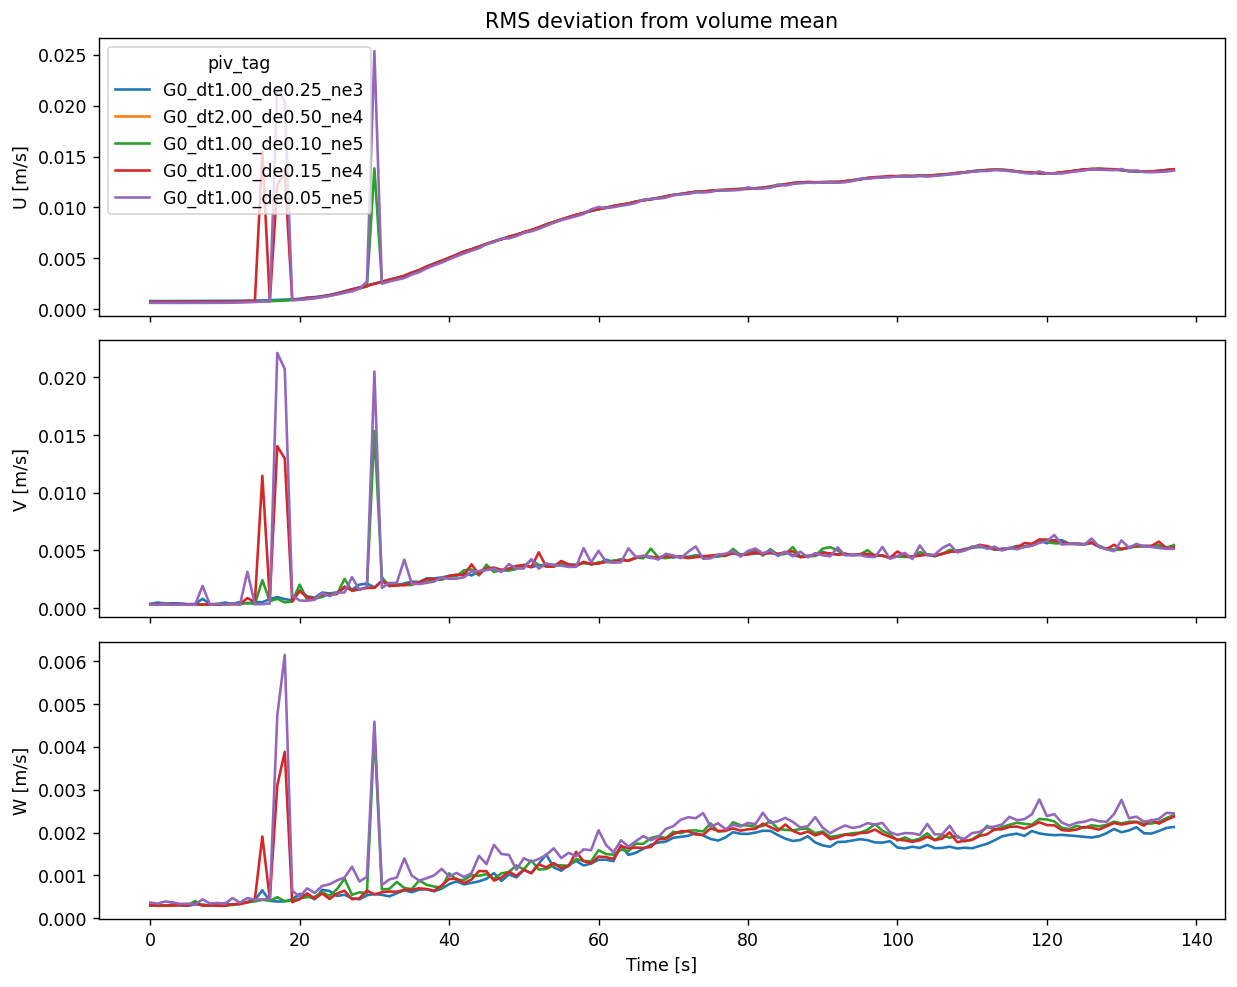

In [6]:
import matplotlib.pyplot as plt
vv = ['U','V','W']
fig,ax = plt.subplots(3,1,figsize=(10,8),dpi=125,sharex=True)
for i,v in enumerate(vv):
    if i > 0:
        legend=False
    else:
        legend=True
        
    rms[v].plot(ax=ax[i],hue='piv_tag',add_legend=legend)
    
    ax[i].set_ylabel(f'{v} [m/s]')
ax[0].set_title('RMS deviation from volume mean')
for a in ax:
    a.set_xlabel('')
a.set_xlabel('Time [s]')
fig.tight_layout()